# Deep Learning Nanodegree

## Convolutional Neural Networks

## Project: Algorithm for a Dog Identification App 

#### Author: Jubin Soni
#### GitHub: <a href='https://github.com/jubins/Deep-Learning-Udacity/blob/master/Convolutional%20Neural%20Networks/Dog-Breed-Classifier-Project/dog_app.ipynb'>Link</a>
---
### Overview

In this project, I have built a convolutional neural network (CNN) that can classify the breed of dog from any user-supplied image. If the image of a dog is detected the algorithm will provide breed of that dog. If the image of a human is detected the algorithm will provide most resembling dog breed. This code is written using Keras and can be used as part of a mobile or web app, and the code can accept any user-supplied image as input.  The image below displays potential sample output of your finished project.

![Sample Dog Output](images/sample_dog_output.png)

The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

Also to mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Dependencies

In this project I have mainly used Keras and Python 3. Entire instructions on setting up your environment and datasets used in this project can be found under the `README.md` file.

### Outline

The notebook is broken into separate steps.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [106]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [107]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

I have used OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, this detector is used to find human faces in a sample image.

Number of faces detected: 1


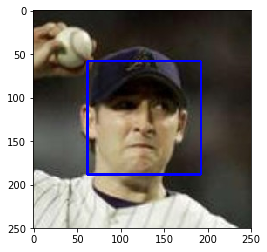

In [44]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[5])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [53]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assessing the Human Face Detector Implemented in OpenCV

In [54]:
## TODO: 
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

#Test the performance of the face_detector algorithmon the images in human_files_short and dog_files_short.
human_count = 0
total = 0
for img in human_files_short:
    isPerson = face_detector(img)
    if not isPerson:
        human_count += 1
        total = 100 - human_count
    percentage = (total/len(human_files_short)) * 100
print('Percentage of humans correctly classified as people: {}%'.format(percentage))

dog_count = 0
for img in dog_files_short:
    isPerson = face_detector(img)
    if isPerson:
        dog_count += 1
    percentage = (dog_count/len(dog_files_short)) * 100
print('Percentage of dogs misclassified as people: {}%'.format(percentage))

Percentage of humans correctly classified as people: 98.0%
Percentage of dogs misclassified as people: 11.0%


As we can see, the face detector isn't perfect as it finds human faces in 11% of the dog photos.

Further, the technique we selected for face detection requires a clear view of a face (ie. doesn't perform well on scenarios and not practical). If we wanted better performance for a wider variety of photo conditions, we could build a CNN specifically for detecting human faces. The training data should include a diverse set of images from a wide variety of angles, lighting conditions, and partial obscurations (wearing a hat, hand in front of face, etc).

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [56]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [50]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img_tensor = path_to_tensor(img_path)
    img = preprocess_input(img_tensor)
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [51]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assessing the Dog Detector implemented using CNN ResNet50

In [57]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_count = 0    
for img in human_files_short:
    isDog = dog_detector(img)
    if isDog:
        human_count += 1
    percentage = (human_count/len(human_files_short)) * 100
print('Percentage of humans misclassified as dogs:: {}%'.format(percentage))

dog_count = 0
for img in dog_files_short:
    isDog = dog_detector(img)
    if isDog:
        dog_count += 1
    percentage = (dog_count/len(dog_files_short)) * 100
print('Percentage of dogs correctly classified as dogs: {}%'.format(percentage))

Percentage of humans misclassified as dogs:: 1.0%
Percentage of dogs correctly classified as dogs: 100.0%


We see a huge difference that in correct classification of human faces here: with CNN we get 100% of dogs classified as dogs and just 1% humans were misclassfied as dogs, as compared to 11% dogs misclassified as humans by OpenCV.

Hence, in the below step 3, I will create a CNN using Keras that classifies dog breeds from scratch. In Step 5 of this notebook, I will use transfer learning to create a CNN that attains greatly improved accuracy.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)


### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 149.83it/s]


### Model Architecture

In this step, I have first done image augmentation by flipping, rotating the umages horizontally and vertically using the Keras ImageDataGenerator, after all the training images have been scaled to a set pixel 255.This way there will be more representative examples for CNN to learn from. Then in my model architechture I have defined the BatchNormalization input shape to (224,244,3), used 5 Conv2D layers as hidden layers and after each Conv2D layer I have used MaxPooling2D layer and BatchNormalization respectively. This way I have avoided overfitting as well as any performance efficiency issue while givng the model enough information/image data to train from.

Overall, the model trains relatively fast on CPU and attains >1% test accuracy in 5 epochs but in my case I have used Amazon AWS GPU on EC2 instance.

![Sample CNN](images/sample_cnn.png)

### Image Augmentation

In [62]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen.fit(train_tensors)

### Defining my own CNN Architecture

In [63]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 54, 54, 32)        128       
__________

### Compile the Model

In [64]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

We train the model in the code cell below and use checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [65]:
epochs = 10
batch_size = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.bestaugmented.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

### Using Image Augmentation
model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/10
334/334 [==============================] - 56s - loss: 4.5176 - acc: 0.0491 - val_loss: 4.4455 - val_acc: 0.0395
Epoch 2/10
334/334 [==============================] - 53s - loss: 4.0578 - acc: 0.0867 - val_loss: 4.0244 - val_acc: 0.0970
Epoch 3/10
334/334 [==============================] - 53s - loss: 3.7375 - acc: 0.1304 - val_loss: 3.6577 - val_acc: 0.1377
Epoch 4/10
334/334 [==============================] - 54s - loss: 3.4298 - acc: 0.1810 - val_loss: 3.5238 - val_acc: 0.1521
Epoch 5/10
334/334 [==============================] - 54s - loss: 3.1646 - acc: 0.2319 - val_loss: 3.1685 - val_acc: 0.2323
Epoch 6/10
334/334 [==============================] - 54s - loss: 2.9126 - acc: 0.2829 - val_loss: 3.0144 - val_acc: 0.2479
Epoch 7/10
334/334 [==============================] - 54s - loss: 2.6766 - acc: 0.3246 - val_loss: 2.9885 - val_acc: 0.2527
Epoch 8/10
334/334 [==============================] - 54s - loss: 2.4686 - acc: 0.3656 - val_loss: 2.7130 - val_acc: 0.3234
Epoch 9/

### Load the Model with the Best Validation Loss

In [66]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [67]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 33.6124%


### More Training
The current accuracy is below 35% which is too low. Resuming training to see if accuracy improves.

In [68]:
batch_size = 20
epochs = 5

model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/5
334/334 [==============================] - 55s - loss: 1.9291 - acc: 0.4969 - val_loss: 2.3412 - val_acc: 0.4000
Epoch 2/5
334/334 [==============================] - 54s - loss: 1.7641 - acc: 0.5392 - val_loss: 2.3844 - val_acc: 0.3916
Epoch 3/5
334/334 [==============================] - 54s - loss: 1.6149 - acc: 0.5678 - val_loss: 2.3139 - val_acc: 0.4084
Epoch 4/5
334/334 [==============================] - 54s - loss: 1.4561 - acc: 0.6066 - val_loss: 2.3389 - val_acc: 0.4036
Epoch 5/5
334/334 [==============================] - 54s - loss: 1.3795 - acc: 0.6281 - val_loss: 2.1952 - val_acc: 0.4299


We see that model training the model does affect our accuracy and current accuracy is 42% so training the model further with different batch-sizes.

In [69]:
batch_size = 20
epochs = 5

model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/5
334/334 [==============================] - 54s - loss: 1.2515 - acc: 0.6600 - val_loss: 2.1277 - val_acc: 0.4539
Epoch 2/5
334/334 [==============================] - 53s - loss: 1.1539 - acc: 0.6882 - val_loss: 2.3026 - val_acc: 0.4323
Epoch 3/5
334/334 [==============================] - 54s - loss: 1.0738 - acc: 0.7064 - val_loss: 2.0192 - val_acc: 0.4790
Epoch 4/5
334/334 [==============================] - 53s - loss: 0.9938 - acc: 0.7313 - val_loss: 2.0898 - val_acc: 0.4539
Epoch 5/5
334/334 [==============================] - 53s - loss: 0.9118 - acc: 0.7509 - val_loss: 2.0878 - val_acc: 0.4479


In [70]:
batch_size = 64
epochs = 5

model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/5
104/104 [==============================] - 55s - loss: 0.5602 - acc: 0.8660 - val_loss: 1.7908 - val_acc: 0.5353
Epoch 2/5
104/104 [==============================] - 52s - loss: 0.4830 - acc: 0.8887 - val_loss: 1.7900 - val_acc: 0.5329
Epoch 3/5
104/104 [==============================] - 51s - loss: 0.4506 - acc: 0.8988 - val_loss: 1.7359 - val_acc: 0.5353
Epoch 4/5
104/104 [==============================] - 51s - loss: 0.4252 - acc: 0.9057 - val_loss: 1.7886 - val_acc: 0.5401
Epoch 5/5
104/104 [==============================] - 52s - loss: 0.3951 - acc: 0.9127 - val_loss: 1.7710 - val_acc: 0.5293


Results: 
- Increasing the training epochs and bacth-size ha increased the accuracy to 91%!
- However we have to tradeoff performance here, as the training was very slow.

### Testing the Model Again

In [71]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 53.2297%


Looking at the results of training set and test set we see that after multiple training iterations model performs with 91% accuracy on the training set but when we test our model against the test set we get just 53% accuracy. It seems our model may be overfitting.

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

In the Step 3, I noticed that implementing my model from scratch involves me to do image augmentation, pre-processing, scaling, training all of which takes a lot of time but performs very well at the end.

In this step, to reduce training time without sacrificing accuracy, I use transfer learning on the VGG16 pre-trained CNN. Then in the next step I will use the same technique on ResNet50 CNN for my algorithm to achieve performance.

### Obtaining Bottleneck Features

In [81]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture VGG16

I haved used the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to the model. Therefore, we only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [108]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the VGG16 Model

In [109]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the VGG16 Model

In [110]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s - loss: 12.3471 - acc: 0.1314 - val_loss: 10.9860 - val_acc: 0.2228
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 10.1961 - acc: 0.2847 - val_loss: 10.1078 - val_acc: 0.2862
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 9.5965 - acc: 0.3427 - val_loss: 9.8363 - val_acc: 0.3150
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 9.2782 - acc: 0.3775 - val_loss: 9.5352 - val_acc: 0.3293
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 8.9159 - acc: 0.4103 - val_loss: 9.3620 - val_acc: 0.3545
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 8.8112 - acc: 0.4290 - val_loss: 9.2698 - val_acc: 0.3665
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 8.7437 - acc: 0.4386 - val_loss: 9.2903 - val_acc: 0.3629
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.5548 

### Loading the VGG16 Model with the Best Validation Loss

In [86]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test our VGG16 Model

To test how well our model identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [111]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 42.9426%


We see that the model is performing with just 42% accuracy this is too low as compared to the model we created from scratch. The reason for this is when we initially see our previous models accuracy was below 35% then retraining on multiple Epochs and Batch sizes gave us the accuracy of 91%. However, using transfer learning on VGG16 model without any retraining gave us accuracy above 40% not to mention the time it took to train was far less. Hence, transfer learning is a good choice.

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

In this step I have use transfer learning to create a CNN that can identify dog breed from images.

Here I have written an algorithm that accepts a file path of image then identifies if the image contains a human, dog or neither.

- If a dog is detected, it returns the predicted breed.
- If a human is detected, it returns the most resembling dog breed.
- If neigther of above two is detected, it just indicates that to the user.

### Obtain Bottleneck Features

In [27]:
import numpy as np

### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### Model Architecture ResNet50

I have used ResNet50 because it has several advantages over VGG16 model. In choosing my model I referred to this <a href='https://arxiv.org/abs/1512.03385'>research paper</a> and had to Google to learn in more detail about this model.
- It has lower complexity and provide deeper neural network
- Solves the vanishing gradient descent problem and being good especially for image classification task.

In my model architechture I used pre-trained ResNet50 model as a fixed feature extractor, where there is just one global average pooling layer and a fully connected layer which has a softmax function that predicts the probability of each breed. Apart this I have used Adamax optimizer and checkpointer to get best validation loss.

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet_model.add(Dense(133, activation='softmax'))

ResNet_model.summary()

### Compile the Model

In [28]:
from keras.optimizers import Adam, Adamax

ResNet_model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.002), metrics=['accuracy'])

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [29]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best_adamax.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 30
batch_size = 64

ResNet_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 1.6201 - acc: 0.5951 - val_loss: 0.8007 - val_acc: 0.7497
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 0.4320 - acc: 0.8663 - val_loss: 0.7488 - val_acc: 0.7796
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 0.2626 - acc: 0.9180 - val_loss: 0.7312 - val_acc: 0.7820
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 0.1788 - acc: 0.9424 - val_loss: 0.6697 - val_acc: 0.8012
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 0.1215 - acc: 0.9605 - val_loss: 0.6885 - val_acc: 0.8168
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 0.0876 - acc: 0.9704 - val_loss: 0.7043 - val_acc: 0.8060
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 0.0634 - acc: 0.9810 - val_loss: 0.7256 - val_acc: 0.8192
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 0.0471 - ac

In [ ]:
opt = Adamax(lr=0.0002)
epochs = 5
batch_size = 64

ResNet_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [30]:
### Load the model weights with the best validation loss.
ResNet_model.load_weights('saved_models/weights.best_adamax.ResNet50.hdf5')

### Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [31]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
ResNet50_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.5024%


### Predict Dog Breed with the Model

Below I have written a function that takes an image path as an input and returns the dog breed name predicted by my mode.
Similar to the analogous function in the Step4, the function has three steps:

1. Extracting the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector. Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in the Step0 of this notebook to return the corresponding breed.

All the functions to extract bottleneck features can be imported from `extract_bottleneck_features.py`.

In [104]:
### This function takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def ResNet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = ResNet_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    breed = dog_names[np.argmax(predicted_vector)]
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    if dog_detector(img_path) == True:
        return "The breed of dog is a {}".format(breed)
    else:
        return "If this person were a dog, the breed would be a {}".format(breed)

### Testing the model on Validation set

In [ ]:
#Testing on the Validation set
file_num = 0
print('Predicted by our model: {}.'.format(ResNet50_predict_breed(valid_files[file_num])))
print('Actual Filename: {}.'.format(valid_files[file_num]))

In [ ]:
#Testing on the Validation set
file_num = 11
print('Predicted by our model: {}.'.format(ResNet50_predict_breed(valid_files[file_num])))
print('Actual Filename: {}.'.format(valid_files[file_num]))

The model is able to correctly classify dog breeds!

---
<a id='step6'></a>
## Step 6: Write Dog Classifier Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


In [105]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

def predict_breed(img_path):
    isDog = dog_detector(img_path)
    isPerson = face_detector(img_path)
    if isDog:
        print("Detected a dog")
        breed = ResNet50_predict_breed(img_path)
        return breed
    if isPerson:
        print("Detected a human face")
        breed = ResNet50_predict_breed(img_path)
        return breed
    else:
        print("No human face or dog detected")
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgplot = plt.imshow(cv_rgb)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
